## Long short-term memory autoencoder

*Autoencoder* — архитектура нейронной сети, которая по входным данным получает выходные данные той же размерности. В зависимости от типа может иметь один или несколько скрытых слоев. Автоенкодеры имеют два модуля: кодировщик (encoder) и декодировщик (decoder). Кодировщик работает со здоровыми данными и изучает как устроены нормальные рабочие процессы системы, а затем сжимает данные в скрытое представление. Декодировщик пытается восстановить из этого представления выходные данные. Все что на выходе не соответсвует нормальному состоянию системы будет определено как аномалия. **Цель** — получить на выходном слое отклик, наиболее близкий к входному.

<img src="./img/ae_scheme.png" alt="Drawing" style="width: 600px; height: 350px"/>

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import warnings 
warnings.filterwarnings('ignore')

from utils.data import create_sequences
from sklearn.preprocessing import StandardScaler
from utils.metrics import mar, far, f1_score

from models.lstm_ae import LSTM_AE

### Process data

In [2]:
df = pd.read_csv("./data/valve1/0.csv", sep=";", parse_dates=True, index_col="datetime")

df.sort_index(inplace=True)

### Make model

In [4]:
from utils.pipeline import Pipeline, Predictor

class Config:
    train_size = 400
    TIME_STEPS = 50
    epochs = 1
    batch_size = 10 
    Q = 0.99
    
conf = Config

class LSTM_AE_Predictor(Predictor):
    def make_prediction(self, df):
        ss = StandardScaler()
        x_train = np.array(ss.fit_transform(df[:conf.train_size].drop(['anomaly','changepoint'], axis=1)))
        x_train = create_sequences(x_train, conf.TIME_STEPS)
        
        model = LSTM_AE()
        model.fit(x_train, conf.epochs, conf.batch_size, conf.TIME_STEPS)
        
        health_r = pd.Series(np.sum(np.mean(np.abs(model.predict(x_train) - x_train), axis=1), axis=1))
        UCL = health_r.quantile(conf.Q)
        
        x_test = df.drop(['anomaly','changepoint'], axis=1)
        x_test = np.array(ss.transform(x_test))
        x_test = create_sequences(x_test, conf.TIME_STEPS)
        
        r = pd.Series(np.sum(np.mean(np.abs(model.predict(x_test) - x_test), axis=1), axis=1))        
        anomalous_data = r > (3/2 * UCL)
        anomalous_data_indices = [] 
        for data_idx in range(conf.TIME_STEPS - 1, len(x_test) - conf.TIME_STEPS + 1):
            if np.all(anomalous_data[data_idx - conf.TIME_STEPS + 1 : data_idx]):
                anomalous_data_indices.append(data_idx - int(conf.TIME_STEPS // 6))
        prediction = pd.Series(data=0, index=df.index)
        prediction.iloc[anomalous_data_indices] = 1
        return prediction

In [4]:
prediction = LSTM_AE_Predictor().make_prediction(df)

36/36 [==============================] - 10s 100ms/step - loss: 0.9081


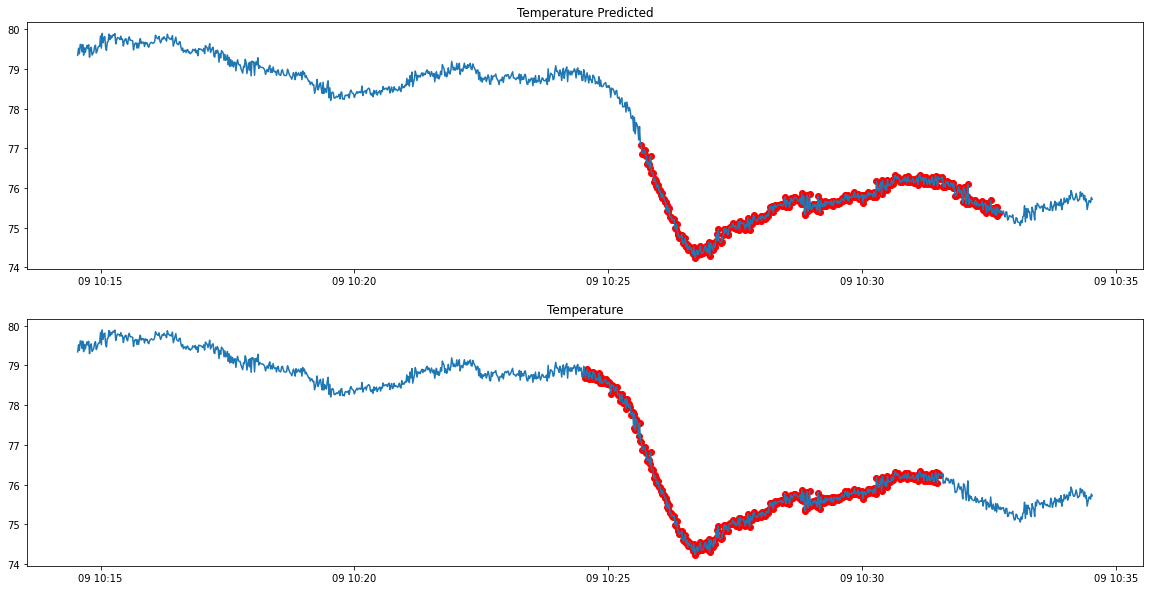

In [5]:
y_test = df.anomaly
fig, axs = plt.subplots(2, 1, figsize=(20,10))
temperatures = df.Temperature
axs[0].plot(temperatures)
axs[1].plot(temperatures)

y = pd.Series(prediction)
anomalies_indecies = y.index[y == 1]
axs[0].scatter(anomalies_indecies, temperatures[anomalies_indecies], color='r')
axs[0].set_title("Temperature Predicted")

y = pd.Series(y_test)
anomalies_indecies = pd.Series(y.values).index[y == 1]
axs[1].scatter(df.index[anomalies_indecies], temperatures[anomalies_indecies], color='r')
axs[1].set_title("Temperature")

plt.show()

In [6]:
print(f"""F1 = {f1_score(y_test, prediction)}
FAR = {far(y_test, prediction)}
MAR = {mar(y_test, prediction)}""")

F1 = 0.8387096774193549
FAR = 0.08981233243967829
MAR = 0.1571072319201995


### Применение метода ко всем датасетам

Anomaly: valve1


IntProgress(value=0, description='Computing', max=16, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 9s 116ms/step - loss: 0.9542
F1 = 0.7936298374453338

FAR = 0.08446544595392794

MAR = 0.23775558725630053

Anomaly: valve2


IntProgress(value=0, description='Computing', max=4, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 9s 123ms/step - loss: 8.6515
F1 = 0.7951204253988113

FAR = 0.14633273703041144

MAR = 0.16216216216216217

Anomaly: other0


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 10s 123ms/step - loss: 0.8963
F1 = 0.9156118143459916

FAR = 0.08525033829499323

MAR = 0.037694013303769404

Anomaly: other1


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 9s 123ms/step - loss: 0.9603
F1 = 0.8852097130242825

FAR = 0.13997308209959622

MAR = 0.0

Anomaly: other2


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 9s 123ms/step - loss: 2.9607
F1 = 0.9050772626931567

FAR = 0.11543624161073826

MAR = 0.0

Anomaly: other3


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 10s 122ms/step - loss: 0.8730
F1 = 0.7915993537964459

FAR = 0.08795669824086604

MAR = 0.20711974110032363

Anomaly: other4


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 9s 132ms/step - loss: 12.6817
F1 = 0.0

FAR = 0.0

MAR = 1.0

Anomaly: other5


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 12s 178ms/step - loss: 1.8160
F1 = 0.9675745784695201

FAR = 0.0

MAR = 0.06281407035175879

Anomaly: other6


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 10s 123ms/step - loss: 1.4721
F1 = 0.4777327935222672

FAR = 0.0

MAR = 0.6861702127659575

Anomaly: other7


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 9s 123ms/step - loss: 0.8925
F1 = 0.9071895424836601

FAR = 0.0955585464333782

MAR = 0.0

Anomaly: other8


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 9s 122ms/step - loss: 1.6248
F1 = 0.9122807017543859

FAR = 0.08771929824561403

MAR = 0.06825938566552901

Anomaly: other9


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 10s 123ms/step - loss: 5.6204
F1 = 0.8384615384615385

FAR = 0.0

MAR = 0.2781456953642384

Anomaly: other10


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 9s 123ms/step - loss: 1.7804
F1 = 0.7713841368584758

FAR = 0.0

MAR = 0.3721518987341772

Anomaly: other11


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 10s 144ms/step - loss: 6.0692
F1 = 0.9178082191780822

FAR = 0.09664429530201342

MAR = 0.0

Anomaly: other12


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 11s 123ms/step - loss: 0.9483
F1 = 0.4682926829268293

FAR = 0.0913978494623656

MAR = 0.6426799007444168

Anomaly: other13


IntProgress(value=0, description='Computing', max=1, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 9s 126ms/step - loss: 1.4279
F1 = 0.0

FAR = 0.0

MAR = 1.0

Anomaly: all


IntProgress(value=0, description='Computing', max=34, style=ProgressStyle(bar_color='#61dc8a'))

36/36 [==============================] - 10s 123ms/step - loss: 0.8759
F1 = 0.7663772369654722

FAR = 0.08481959398372647

MAR = 0.28063059615826125



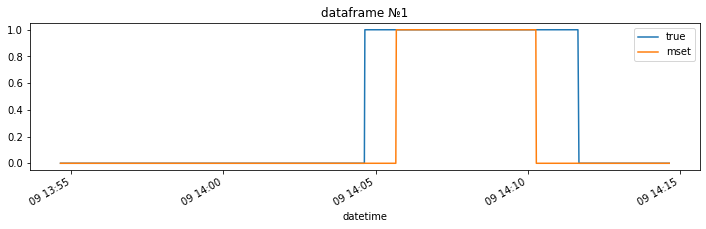

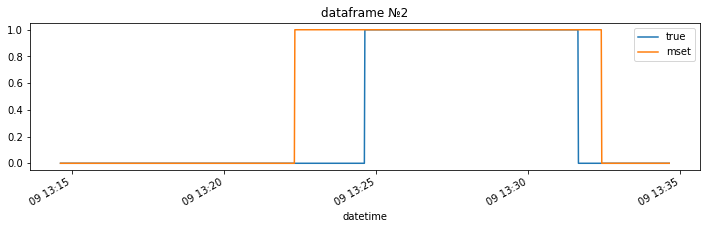

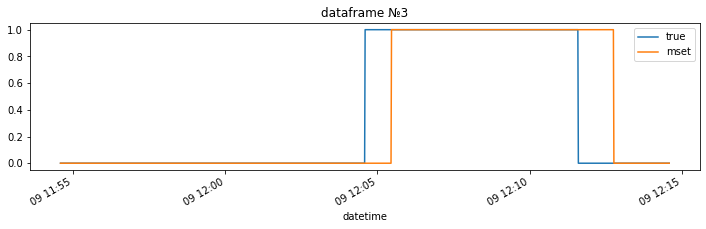

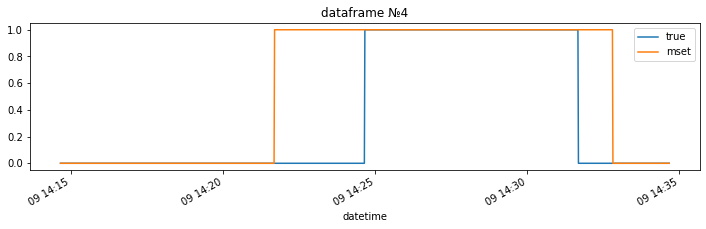

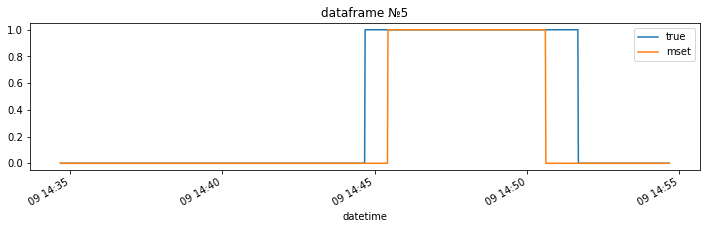

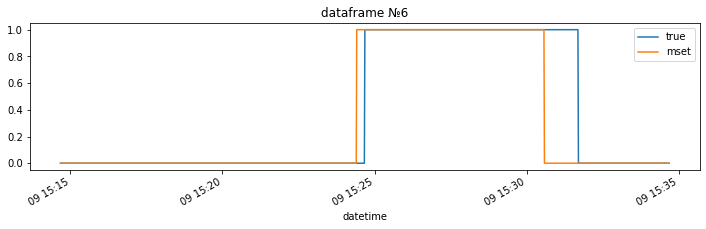

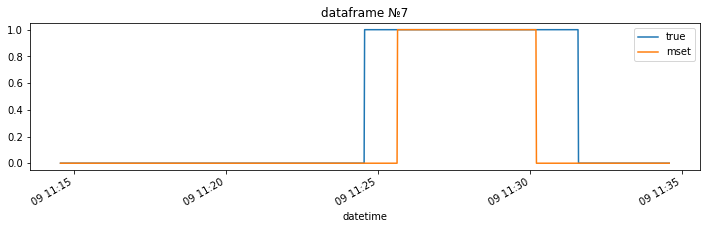

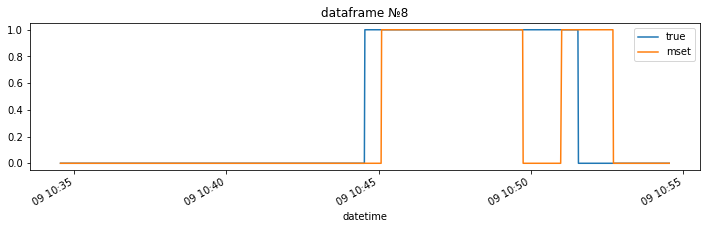

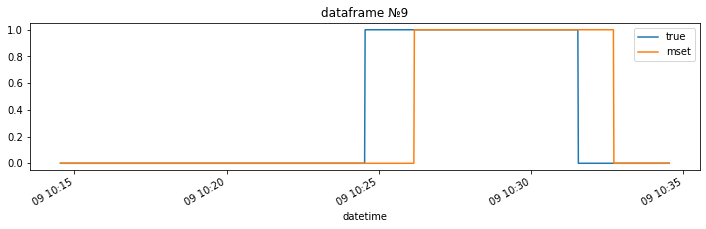

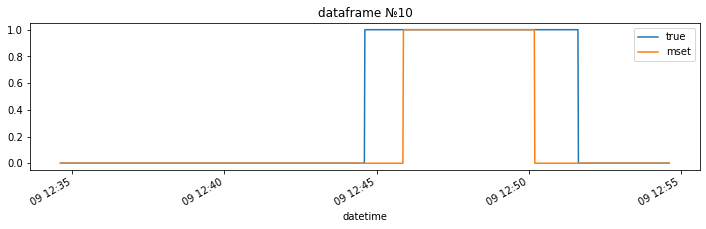

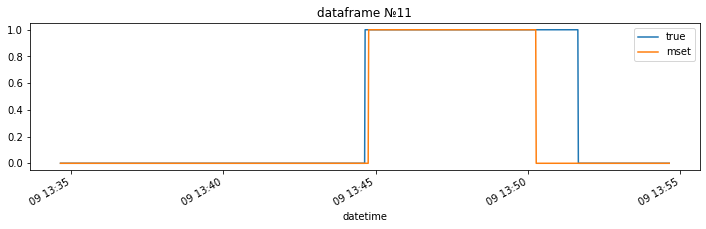

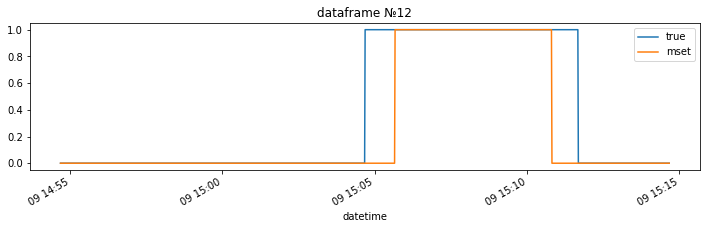

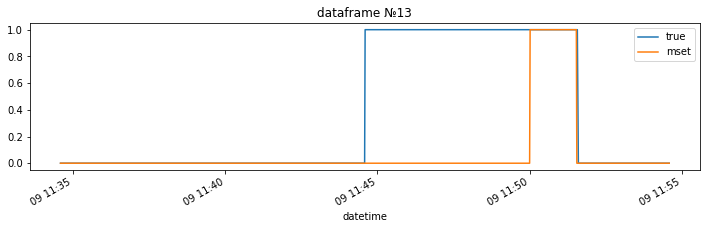

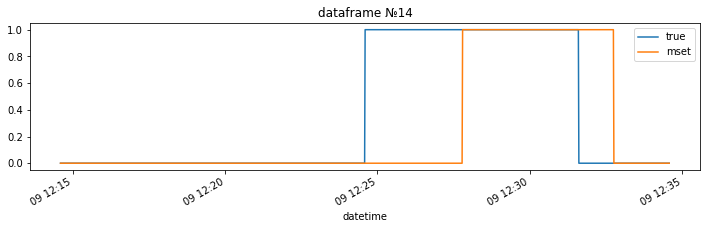

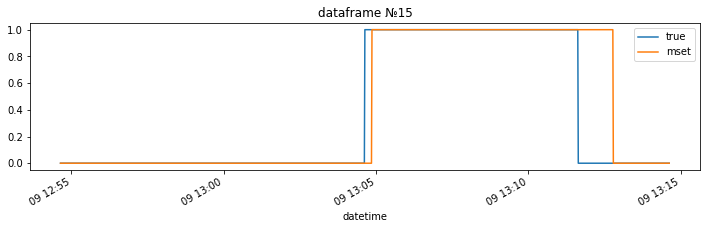

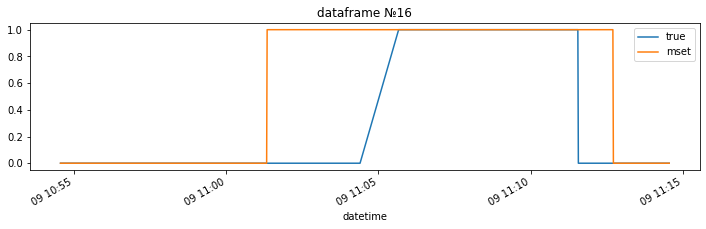

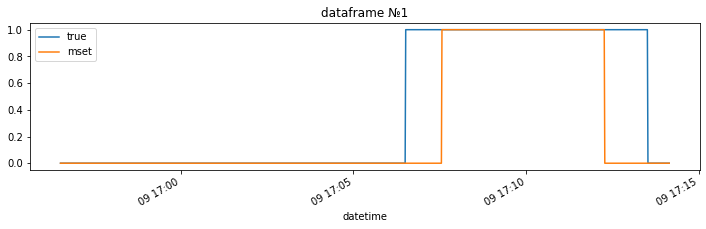

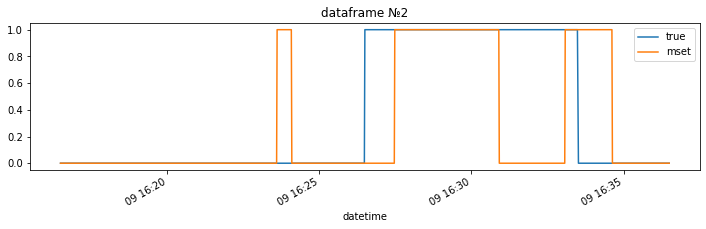

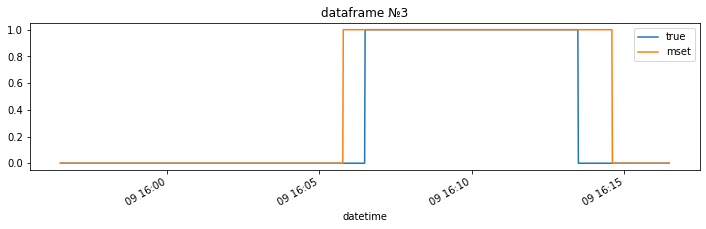

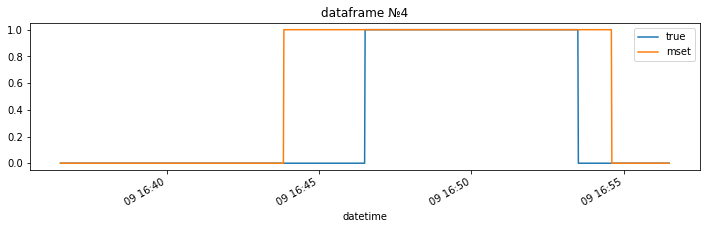

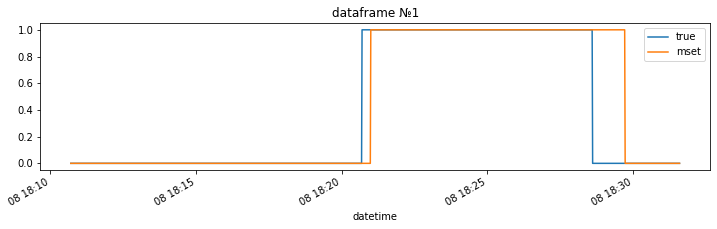

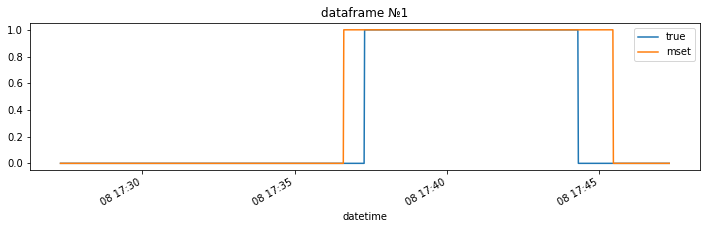

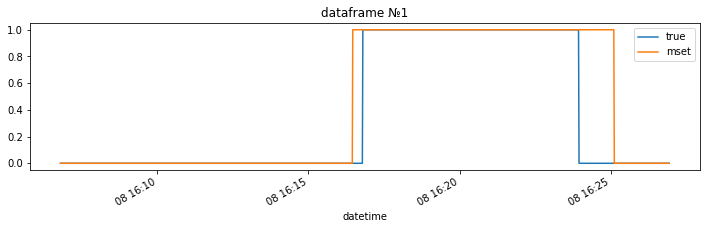

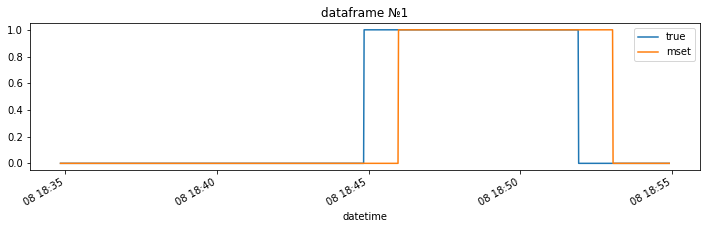

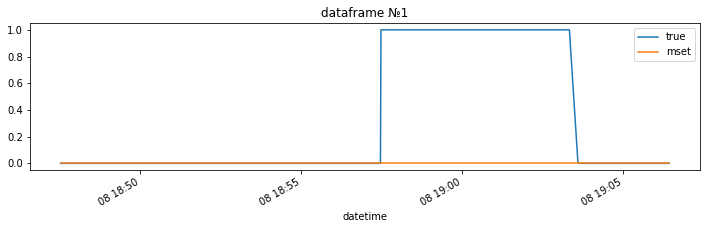

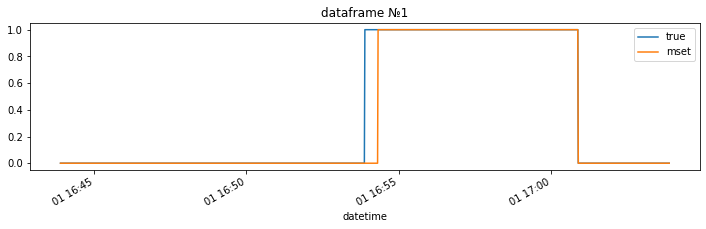

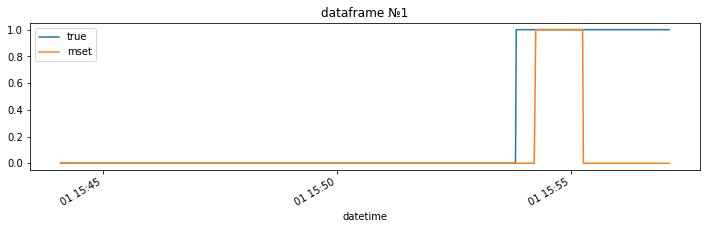

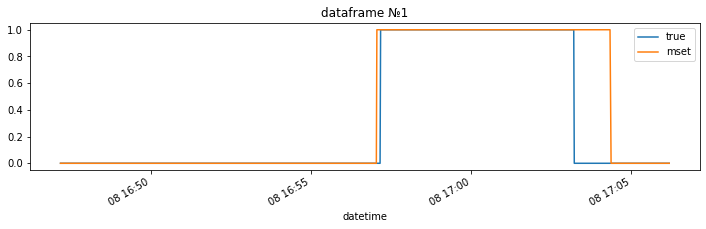

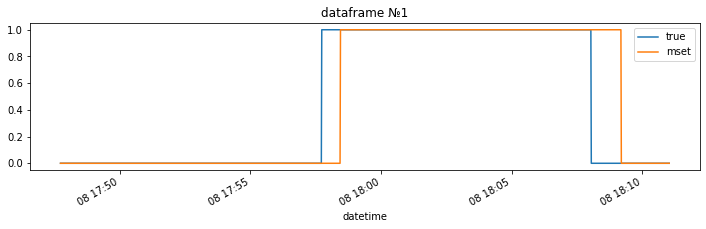

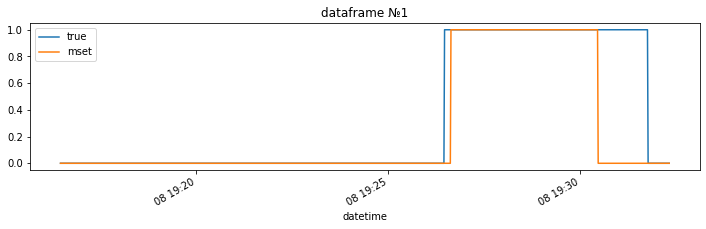

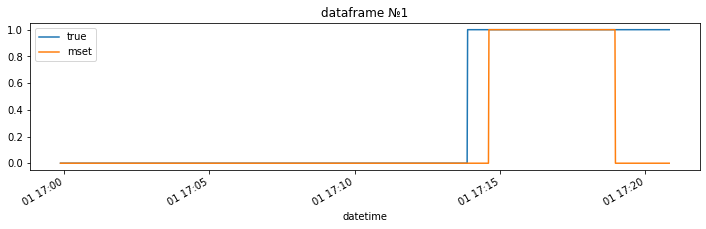

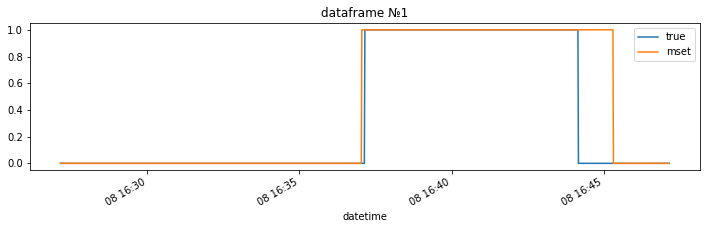

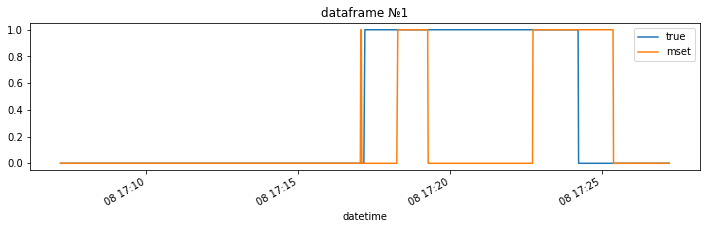

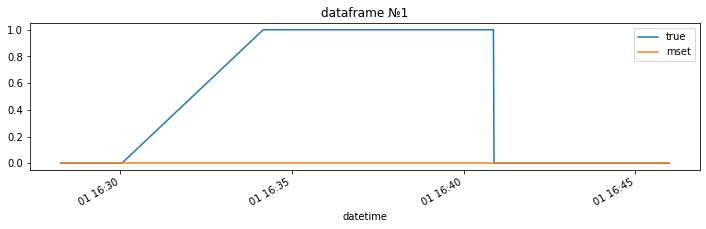

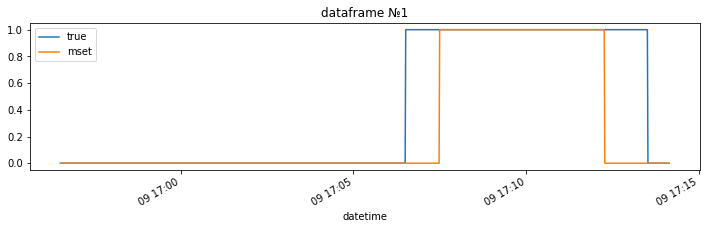

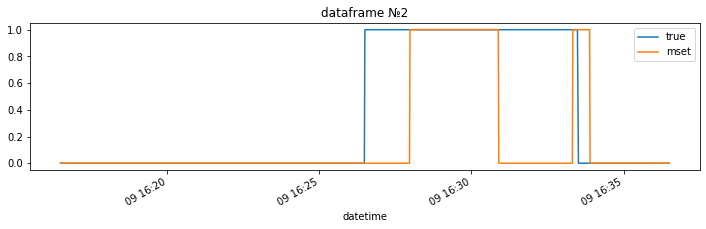

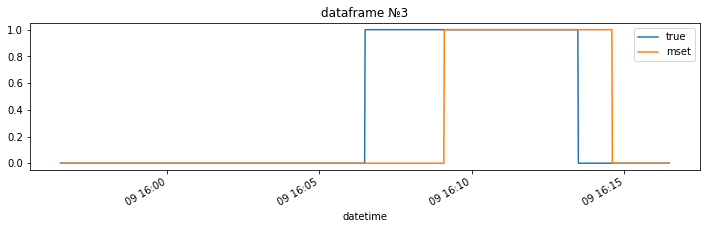

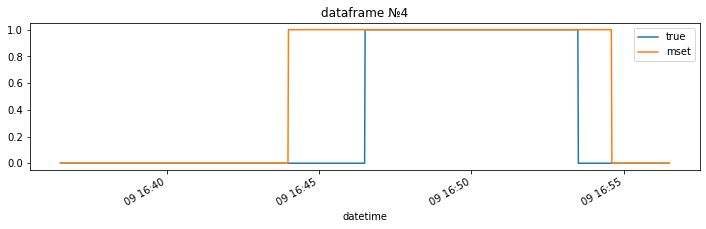

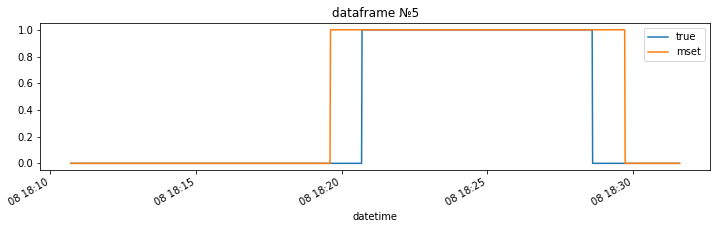

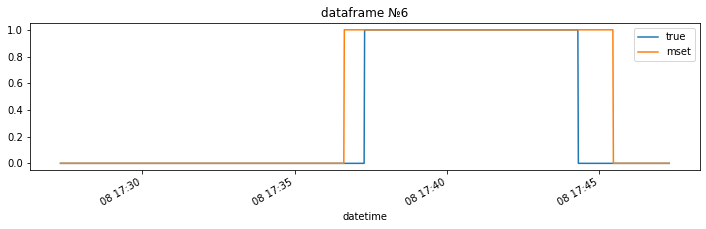

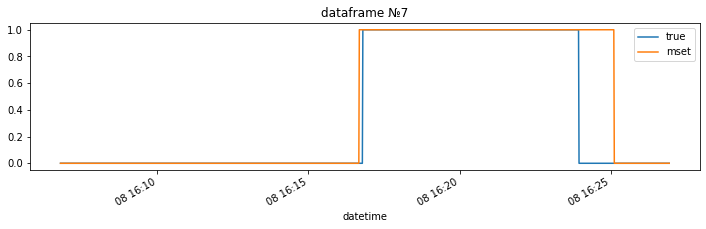

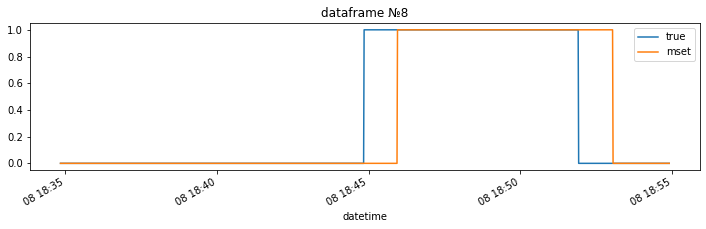

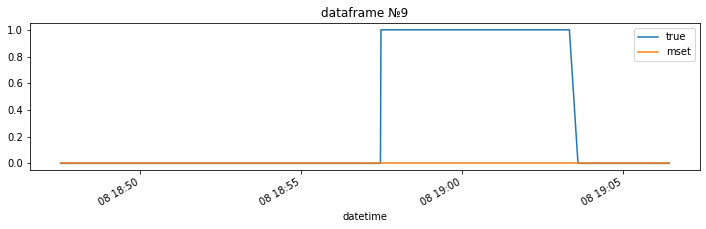

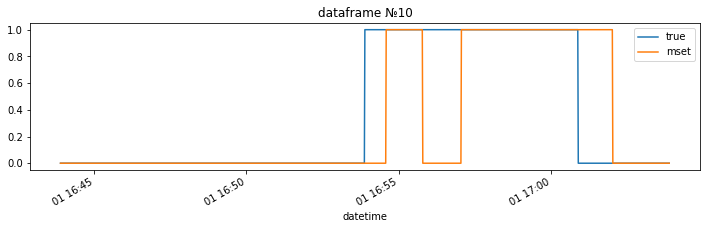

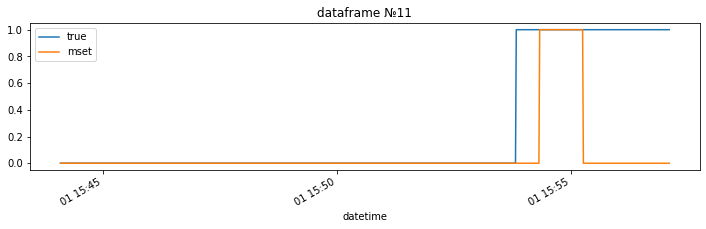

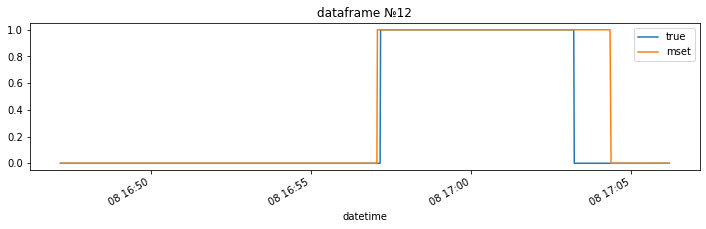

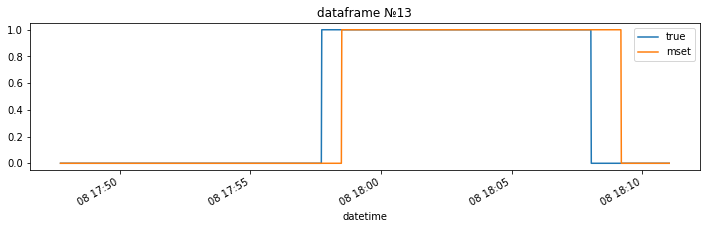

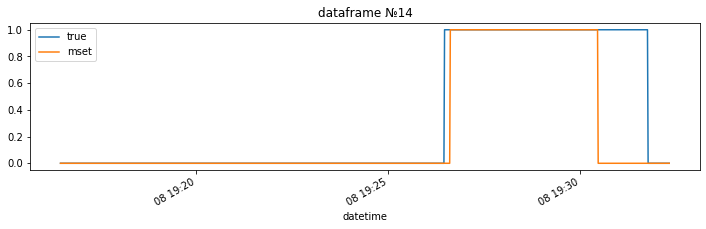

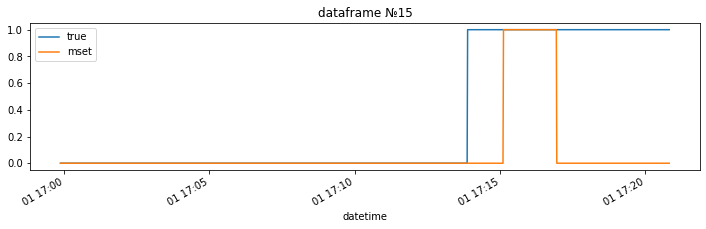

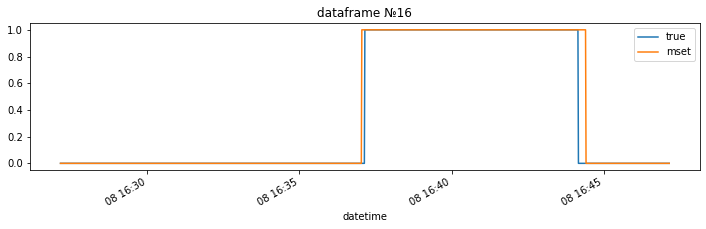

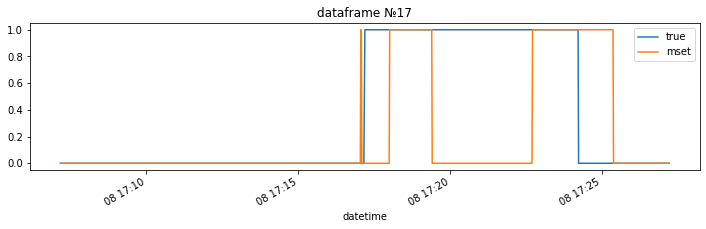

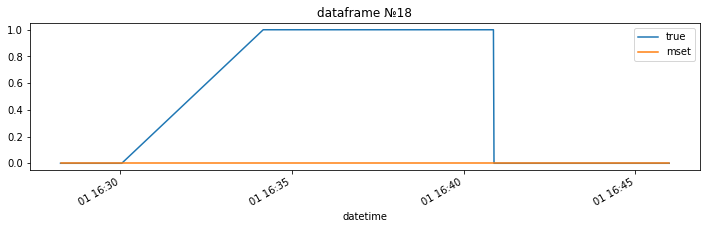

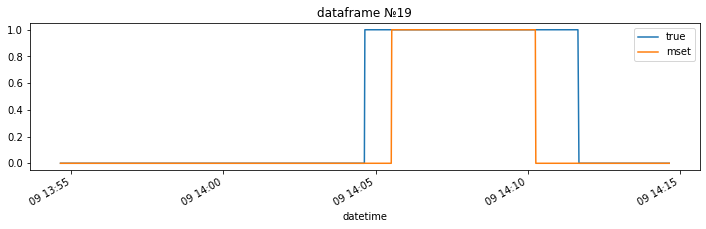

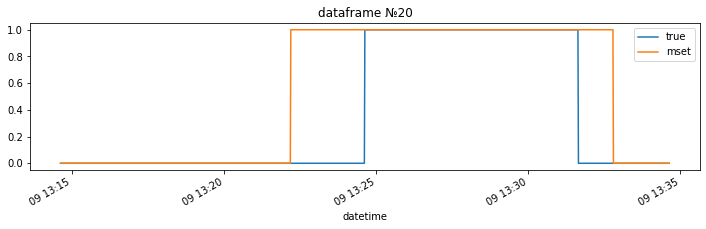

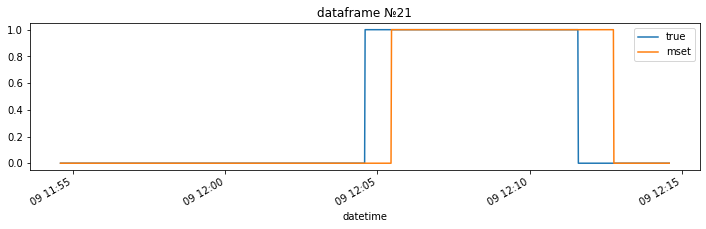

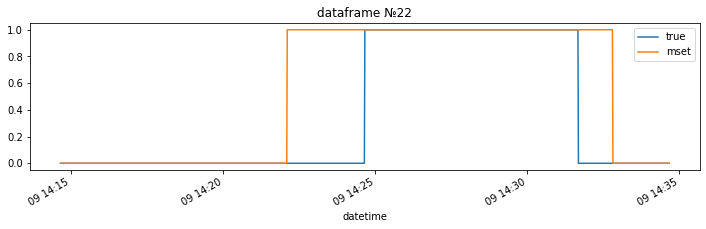

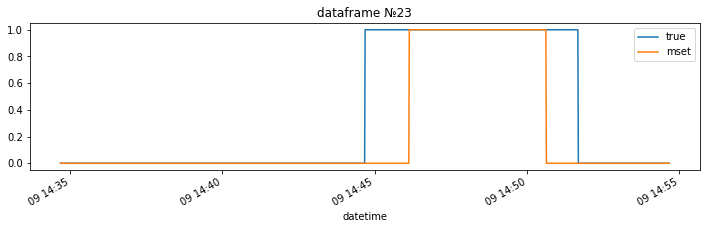

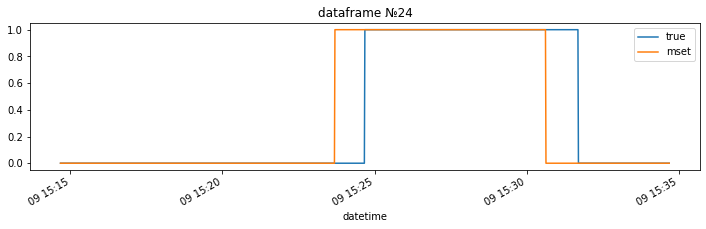

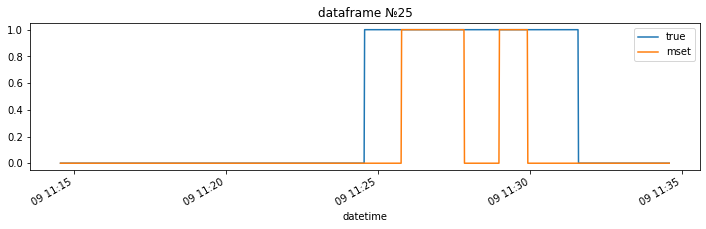

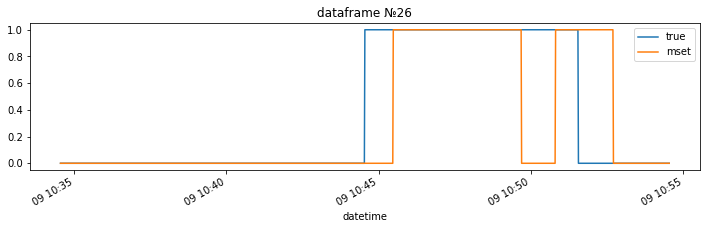

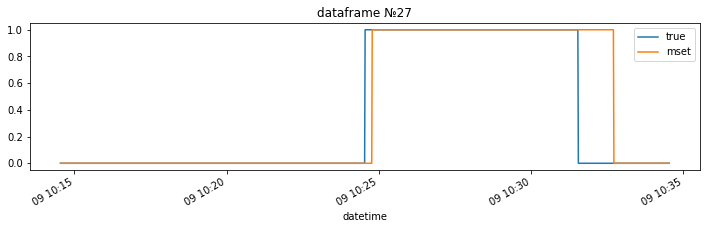

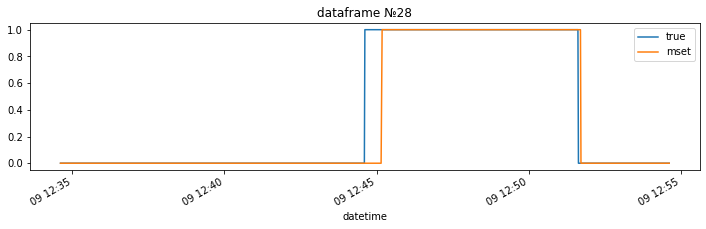

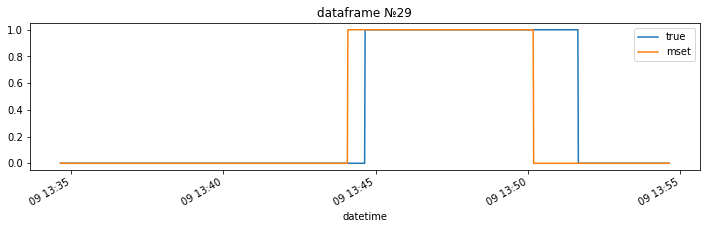

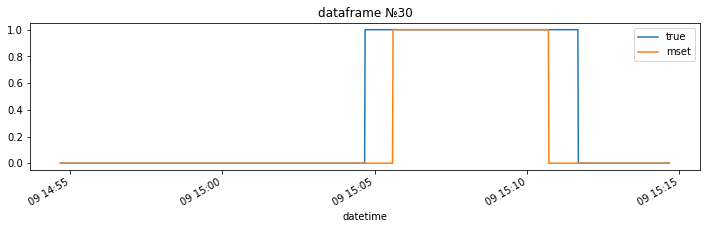

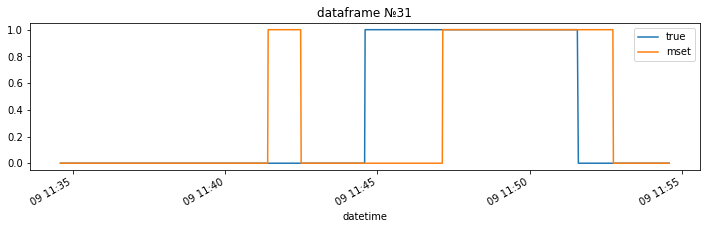

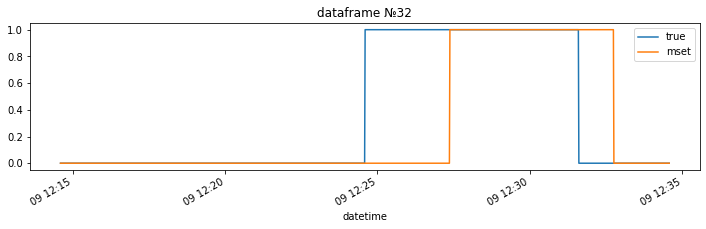

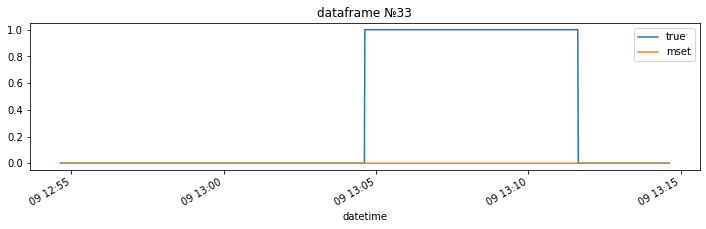

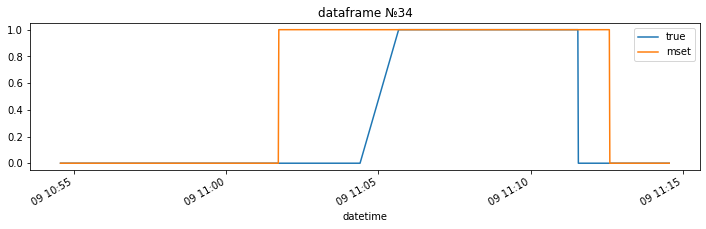

In [7]:
from utils.data import load_df

anomaly_types = ("valve1", "valve2", "other", "all", )
anomaly_groups = dict()

for anomaly_type in anomaly_types:
    list_of_df, _ = load_df("./data/", anomaly_type)
    if anomaly_type == "other":
        for i, df in enumerate(list_of_df):
            anomaly_groups[f"{anomaly_type}{i}"] = [df, ]
    else:
        anomaly_groups[f"{anomaly_type}"] = list_of_df

predictor = LSTM_AE_Predictor()
p = Pipeline()

metrics = dict()

for anomaly_type, list_of_df in anomaly_groups.items():
    metric = p.run(list_of_df, predictor, anomaly_description=anomaly_type)
    metrics[anomaly_type] = metric

In [8]:
from utils.data import show_score_table

show_score_table(metrics)

metric | valve1 | valve2 | other0 | other1 | other2 | other3 | other4 | other5 | other6 | other7 | other8 | other9 | other10 | other11 | other12 | other13 | all
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
F1 |0.79 | 0.8 | 0.92 | 0.89 | 0.91 | 0.79 | 0.0 | 0.97 | 0.48 | 0.91 | 0.91 | 0.84 | 0.77 | 0.92 | 0.47 | 0.0 | 0.77
FAR |0.08 | 0.15 | 0.09 | 0.14 | 0.12 | 0.09 | 0.0 | 0.0 | 0.0 | 0.1 | 0.09 | 0.0 | 0.0 | 0.1 | 0.09 | 0.0 | 0.08
MAR |0.24 | 0.16 | 0.04 | 0.0 | 0.0 | 0.21 | 1.0 | 0.06 | 0.69 | 0.0 | 0.07 | 0.28 | 0.37 | 0.0 | 0.64 | 1.0 | 0.28